=== SETUP AND IMPORTS ===

In [1]:
# Ensure the latest version of the code is used by re-cloning the repository
!rm -rf Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update
!git clone https://github.com/trongjhuongwr/Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update.git
%cd Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update

Cloning into 'Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 171 (delta 74), reused 136 (delta 42), pack-reused 0 (from 0)
Receiving objects: 100% (171/171), 434.16 KiB | 12.06 MiB/s, done.
Resolving deltas: 100% (74/74), done.
/kaggle/working/Deep-Learning-Based-Signature-Forgery-Detection-for-Personal-Identity-Authentication-Update


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import random
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.getcwd()))

from dataloader.tSSN_trainloader import SignaturePretrainDataset
from models.Triplet_Siamese_Similarity_Network import tSSN
from losses.triplet_loss import TripletLoss

print("Setup and Imports successful!")

Setup and Imports successful!


=== CONFIGURATION ===

In [3]:
# Training Hyperparameters
NUM_EPOCHS = 35       # Number of epochs for pre-training (35-50 is usually sufficient)
LEARNING_RATE = 1e-4  # Learning rate for the Adam optimizer
BATCH_SIZE = 32       # Batch size for triplet processing
MARGIN = 0.5          # Margin for the Triplet Loss
DISTANCE_MODE = 'euclidean' # Fixed distance metric for pre-training
OUTPUT_DIM = 512      # Feature dimension from ResNet-34

# Device Configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Paths (Adjust based on your Kaggle dataset input paths)
BASE_DATA_DIR = '/kaggle/input/cedardataset/signatures'
ORG_DIR = os.path.join(BASE_DATA_DIR, 'full_org')
FORG_DIR = os.path.join(BASE_DATA_DIR, 'full_forg')
SAVE_DIR = '/kaggle/working/pretrained_models' # Directory to save the pre-trained weights
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"Pre-trained model will be saved to: {SAVE_DIR}")

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Determine number of workers based on environment
NUM_WORKERS = 2 if 'kaggle' in os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '') else 0

Using device: cuda
Pre-trained model will be saved to: /kaggle/working/pretrained_models


=== DATA LOADING AND PREPROCESSING ===

In [4]:
# Define image transformations (must be consistent with meta-training)
transform = transforms.Compose([
    transforms.Resize((220, 150)),
    transforms.Grayscale(), # Ensure single channel first
    transforms.ToTensor(), # Convert to tensor [0, 1] and CxHxW format
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Convert grayscale to 3 channels for ResNet
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalize to [-1, 1] range
])

# Instantiate the pre-training dataset
try:
    pretrain_dataset = SignaturePretrainDataset(
        org_dir=ORG_DIR,
        forg_dir=FORG_DIR,
        transform=transform
    )
    
    # Create the DataLoader
    pretrain_loader = DataLoader(
        pretrain_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True if DEVICE.type == 'cuda' else False
    )
    print(f"Successfully loaded {len(pretrain_dataset)} triplets for pre-training.")

except FileNotFoundError as e:
    print(f"Error initializing dataset: {e}")
    print("Please ensure BASE_DATA_DIR points to the correct CEDAR dataset location.")
    raise
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")
    raise

Generated 1320 triplets for pre-training.
Successfully loaded 1320 triplets for pre-training.


=== MODEL, LOSS, AND OPTIMIZER INITIALIZATION ===

In [5]:
# Initialize the tSSN model (which wraps the ResNetFeatureExtractor)
# Use ResNet-34 as backbone, output_dim 512, load ImageNet pre-trained weights
model = tSSN(backbone_name='resnet34', output_dim=OUTPUT_DIM, pretrained=True).to(DEVICE)

# Handle multi-GPU if available (optional, but good practice)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for pre-training.")
    model = nn.DataParallel(model)

# Initialize the standard Triplet Loss function
loss_fn = TripletLoss(margin=MARGIN, mode=DISTANCE_MODE).to(DEVICE)

# Initialize the Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Optional: Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print("Model, Loss function, and Optimizer initialized.")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 211MB/s]


Model, Loss function, and Optimizer initialized.


=== PRE-TRAINING LOOP ===

In [6]:
print(f"\n--- Starting Feature Extractor Pre-training for {NUM_EPOCHS} epochs ---")

train_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    num_valid_batches = 0

    progress_bar = tqdm(pretrain_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", leave=False)

    for batch_idx, batch_data in enumerate(progress_bar):
        if batch_data is None:
            print(f"Warning: Skipping problematic batch {batch_idx}.")
            continue

        try:
            anchor, positive, negative = batch_data
            
            if anchor.size(0) == 0 or positive.size(0) == 0 or negative.size(0) == 0:
                print(f"Warning: Skipping batch {batch_idx} due to empty tensor.")
                continue
                
            anchor, positive, negative = anchor.to(DEVICE), positive.to(DEVICE), negative.to(DEVICE)
            optimizer.zero_grad()

            anchor_feat, positive_feat, negative_feat = model(anchor, positive, negative)

            loss = loss_fn(anchor_feat, positive_feat, negative_feat)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_valid_batches += 1
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        except Exception as e:
            print(f"Error during training batch {batch_idx}: {e}")
            continue

    if num_valid_batches > 0:
        epoch_loss = running_loss / num_valid_batches
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Average Loss: {epoch_loss:.4f} - LR: {scheduler.get_last_lr()[0]:.6f}")
    else:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS} - No valid batches processed.")
        train_losses.append(float('nan'))

    scheduler.step()

print("--- Pre-training Finished ---")


--- Starting Feature Extractor Pre-training for 35 epochs ---


Epoch 1/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1/35 - Average Loss: 0.0682 - LR: 0.000100


Epoch 2/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2/35 - Average Loss: 0.0312 - LR: 0.000100


Epoch 3/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3/35 - Average Loss: 0.0113 - LR: 0.000100


Epoch 4/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4/35 - Average Loss: 0.0041 - LR: 0.000100


Epoch 5/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5/35 - Average Loss: 0.0023 - LR: 0.000100


Epoch 6/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6/35 - Average Loss: 0.0010 - LR: 0.000100


Epoch 7/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7/35 - Average Loss: 0.0015 - LR: 0.000100


Epoch 8/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8/35 - Average Loss: 0.0053 - LR: 0.000100


Epoch 9/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9/35 - Average Loss: 0.0054 - LR: 0.000100


Epoch 10/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10/35 - Average Loss: 0.0046 - LR: 0.000100


Epoch 11/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11/35 - Average Loss: 0.0105 - LR: 0.000050


Epoch 12/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12/35 - Average Loss: 0.0000 - LR: 0.000050


Epoch 13/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 13/35 - Average Loss: 0.0000 - LR: 0.000050


Epoch 14/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14/35 - Average Loss: 0.0013 - LR: 0.000050


Epoch 15/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15/35 - Average Loss: 0.0013 - LR: 0.000050


Epoch 16/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 16/35 - Average Loss: 0.0000 - LR: 0.000050


Epoch 17/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 17/35 - Average Loss: 0.0007 - LR: 0.000050


Epoch 18/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 18/35 - Average Loss: 0.0000 - LR: 0.000050


Epoch 19/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 19/35 - Average Loss: 0.0011 - LR: 0.000050


Epoch 20/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 20/35 - Average Loss: 0.0002 - LR: 0.000050


Epoch 21/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 21/35 - Average Loss: 0.0019 - LR: 0.000025


Epoch 22/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 22/35 - Average Loss: 0.0003 - LR: 0.000025


Epoch 23/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 23/35 - Average Loss: 0.0010 - LR: 0.000025


Epoch 24/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 24/35 - Average Loss: 0.0000 - LR: 0.000025


Epoch 25/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 25/35 - Average Loss: 0.0000 - LR: 0.000025


Epoch 26/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 26/35 - Average Loss: 0.0000 - LR: 0.000025


Epoch 27/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 27/35 - Average Loss: 0.0000 - LR: 0.000025


Epoch 28/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 28/35 - Average Loss: 0.0010 - LR: 0.000025


Epoch 29/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 29/35 - Average Loss: 0.0000 - LR: 0.000025


Epoch 30/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 30/35 - Average Loss: 0.0011 - LR: 0.000025


Epoch 31/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 31/35 - Average Loss: 0.0012 - LR: 0.000013


Epoch 32/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 32/35 - Average Loss: 0.0000 - LR: 0.000013


Epoch 33/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 33/35 - Average Loss: 0.0004 - LR: 0.000013


Epoch 34/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 34/35 - Average Loss: 0.0008 - LR: 0.000013


Epoch 35/35:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 35/35 - Average Loss: 0.0000 - LR: 0.000013
--- Pre-training Finished ---


=== SAVE THE PRE-TRAINED FEATURE EXTRACTOR WEIGHTS ===

In [7]:
model_to_save = model.module if isinstance(model, nn.DataParallel) else model
feature_extractor_state_dict = model_to_save.feature_extractor.state_dict()

save_path = os.path.join(SAVE_DIR, 'pretrained_feature_extractor.pth')

try:
    torch.save(feature_extractor_state_dict, save_path)
    print(f"\nPre-trained Feature Extractor weights saved successfully to: {save_path}")
except Exception as e:
    print(f"\nError saving model weights: {e}")


Pre-trained Feature Extractor weights saved successfully to: /kaggle/working/pretrained_models/pretrained_feature_extractor.pth


=== PLOT TRAINING LOSS ===

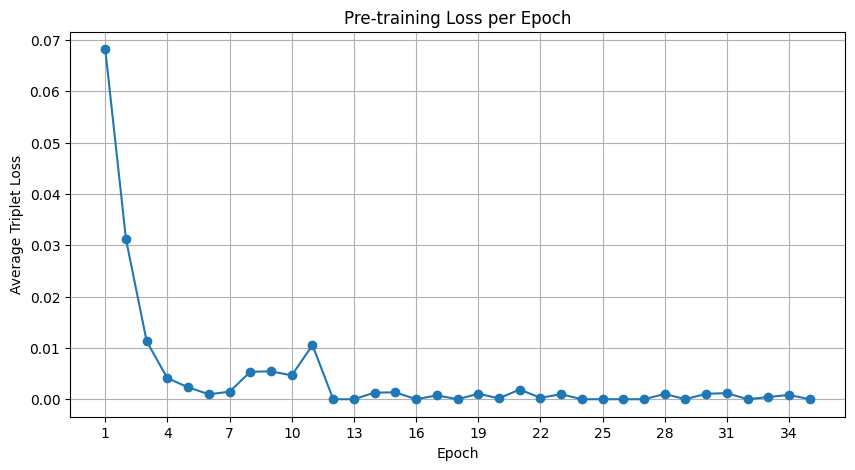

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-')
plt.title('Pre-training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Triplet Loss')
plt.grid(True)
plt.xticks(range(1, len(train_losses) + 1, max(1, len(train_losses) // 10)))
plt.show()